In [7]:
import os

def load_acdc_data(data_path):
    """
    Load images and masks from the ACDC dataset.
    Args:
        data_path (str): Path to the dataset directory (training or testing).
    Returns:
        tuple: Two lists containing paths to images and masks.
    """
    images, masks = [], []

    for patient_folder in os.listdir(data_path):
        patient_path = os.path.join(data_path, patient_folder)
        if os.path.isdir(patient_path):
            for file in os.listdir(patient_path):
                if file.endswith('_gt.nii.gz'):  # Mask files
                    masks.append(os.path.join(patient_path, file))
                elif '_frame' in file and not file.endswith('_gt.nii.gz'):  # Image files
                    images.append(os.path.join(patient_path, file))

    images.sort()
    masks.sort()

    if len(images) != len(masks):
        raise ValueError(f"Mismatch in counts: {len(images)} images and {len(masks)} masks.")

    print(f"Loaded {len(images)} images and {len(masks)} masks from {data_path}.")
    return images, masks

# Paths
train_data_path = "D:/1/Mohsin/ACDC/database/training"
test_data_path = "D:/1/Mohsin/ACDC/database/testing"

# Load data
train_images, train_masks = load_acdc_data(train_data_path)
test_images, test_masks = load_acdc_data(test_data_path)


Loaded 200 images and 200 masks from D:/1/Mohsin/ACDC/database/training.
Loaded 100 images and 100 masks from D:/1/Mohsin/ACDC/database/testing.


In [8]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation sets
train_images_split, val_images, train_masks_split, val_masks = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

print(f"Training images: {len(train_images_split)}, Validation images: {len(val_images)}")
print(f"Training masks: {len(train_masks_split)}, Validation masks: {len(val_masks)}")


Training images: 160, Validation images: 40
Training masks: 160, Validation masks: 40


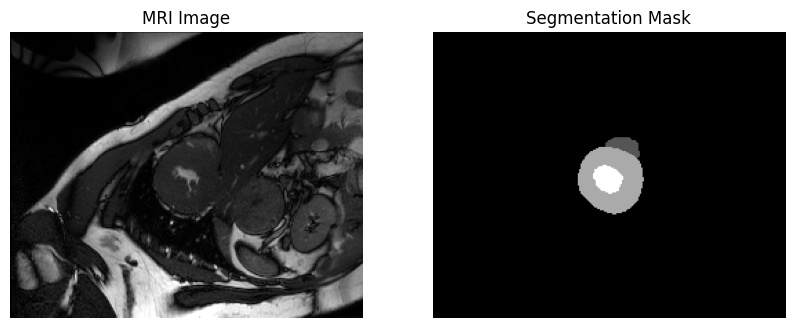

In [9]:
import nibabel as nib
import matplotlib.pyplot as plt

def visualize_sample(image_path, mask_path):
    """
    Visualize the middle slice of an image and its mask.
    """
    image_nii = nib.load(image_path)
    mask_nii = nib.load(mask_path)

    image_data = image_nii.get_fdata()
    mask_data = mask_nii.get_fdata()

    middle_slice = image_data.shape[2] // 2

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_data[:, :, middle_slice], cmap="gray")
    plt.title("MRI Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_data[:, :, middle_slice], cmap="gray")
    plt.title("Segmentation Mask")
    plt.axis("off")
    plt.show()

# Visualize a training sample
visualize_sample(train_images_split[0], train_masks_split[0])


In [10]:
from torchvision import transforms as T

# Define augmentation for images and masks
image_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((128, 128)),  # Resize to match model input size
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
])

mask_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((128, 128)),  # Ensure mask size matches image
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
])


In [11]:
from torch.utils.data import Dataset, DataLoader
import torch

class MRIDataset(Dataset):
    def __init__(self, images, masks, image_transforms, mask_transforms):
        self.images = images
        self.masks = masks
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]

        # Load NIfTI files
        image_data = nib.load(image_path).get_fdata()
        mask_data = nib.load(mask_path).get_fdata()

        # Extract middle slice
        middle_slice = image_data.shape[2] // 2
        image_slice = image_data[:, :, middle_slice]
        mask_slice = mask_data[:, :, middle_slice]

        # Apply transforms
        image_tensor = self.image_transforms(image_slice.astype("float32"))
        mask_tensor = self.mask_transforms(mask_slice.astype("float32"))

        return image_tensor, mask_tensor

# Create datasets
train_dataset = MRIDataset(train_images_split, train_masks_split, image_transforms, mask_transforms)
val_dataset = MRIDataset(val_images, val_masks, image_transforms, mask_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [12]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)


In [13]:
import torch.optim as optim

# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)

        # Ensure output and mask sizes match
        outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:])

        # Compute loss
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")


Epoch 1/10, Loss: 0.706843814253807
Epoch 2/10, Loss: 0.6761749625205994
Epoch 3/10, Loss: 0.6467827498912812
Epoch 4/10, Loss: 0.6185534507036209
Epoch 5/10, Loss: 0.5910045892000199
Epoch 6/10, Loss: 0.5629760980606079
Epoch 7/10, Loss: 0.5346523940563201
Epoch 8/10, Loss: 0.5054471343755722
Epoch 9/10, Loss: 0.4757095515727997
Epoch 10/10, Loss: 0.44715569317340853


In [14]:
import numpy as np

def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target)
    dice = (2.0 * intersection + epsilon) / (union + epsilon)
    return dice

# Evaluate the model on the validation set
model.eval()
dice_scores = []
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:])
        preds = (outputs > 0.5).float()

        # Compute Dice coefficient
        for pred, mask in zip(preds, masks):
            dice_scores.append(dice_coefficient(pred.cpu().numpy(), mask.cpu().numpy()))

print(f"Mean Dice Score: {np.mean(dice_scores):.4f}")


Mean Dice Score: 0.0000


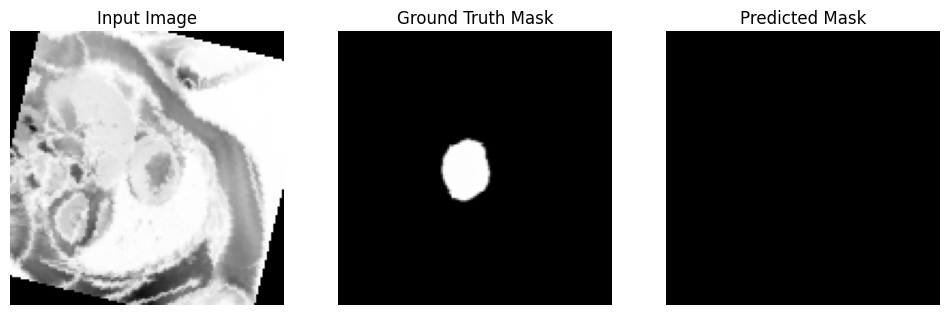

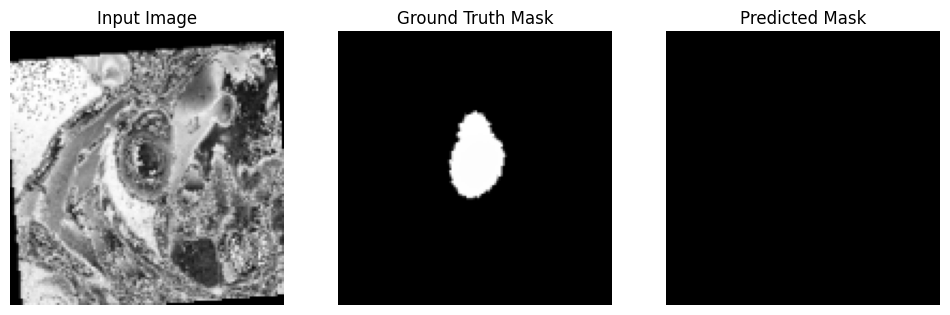

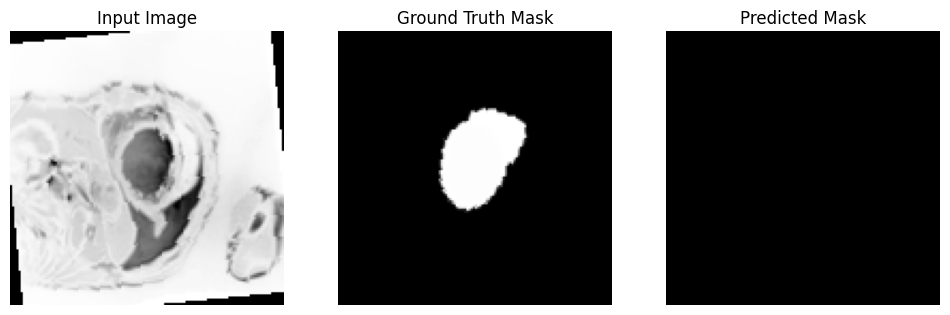

In [19]:
def visualize_predictions(model, loader, num_samples=3):
    model.eval()
    count = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:])
            preds = (outputs > 0.5).float()

            for i in range(images.shape[0]):
                if count >= num_samples:
                    return
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(images[i, 0].cpu(), cmap="gray")
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(masks[i, 0].cpu(), cmap="gray")
                plt.title("Ground Truth Mask")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(preds[i, 0].cpu(), cmap="gray")
                plt.title("Predicted Mask")
                plt.axis("off")

                plt.show()
                count += 1

# Visualize predictions
visualize_predictions(model, val_loader)


In [16]:
# Testing on Unseen Data

In [17]:
# Load the testing dataset
test_dataset = MRIDataset(test_images, test_masks, image_transforms, mask_transforms)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Evaluate on testing data
dice_scores_test = []
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:])
        preds = (outputs > 0.5).float()

        for pred, mask in zip(preds, masks):
            dice_scores_test.append(dice_coefficient(pred.cpu().numpy(), mask.cpu().numpy()))

print(f"Mean Dice Score on Test Data: {np.mean(dice_scores_test):.4f}")


Mean Dice Score on Test Data: 0.0000


In [20]:
import numpy as np

def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target)
    dice = (2.0 * intersection + epsilon) / (union + epsilon)
    return dice

def iou(pred, target, epsilon=1e-6):
    intersection = np.sum(pred * target)
    union = np.sum(pred + target) - intersection
    iou_score = (intersection + epsilon) / (union + epsilon)
    return iou_score

def accuracy(pred, target):
    correct = np.sum(pred == target)
    total = np.prod(target.shape)
    return correct / total

# Evaluate metrics on validation dataset
model.eval()
dice_scores, iou_scores, accuracy_scores = [], [], []

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:])
        preds = (outputs > 0.5).float()

        # Compute metrics for each sample
        for pred, mask in zip(preds, masks):
            pred_np = pred.cpu().numpy()
            mask_np = mask.cpu().numpy()
            dice_scores.append(dice_coefficient(pred_np, mask_np))
            iou_scores.append(iou(pred_np, mask_np))
            accuracy_scores.append(accuracy(pred_np, mask_np))

# Print mean metrics
print(f"Mean Dice Score: {np.mean(dice_scores):.4f}")
print(f"Mean IoU: {np.mean(iou_scores):.4f}")
print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f}")


Mean Dice Score: 0.0000
Mean IoU: 0.0000
Mean Accuracy: 0.9560


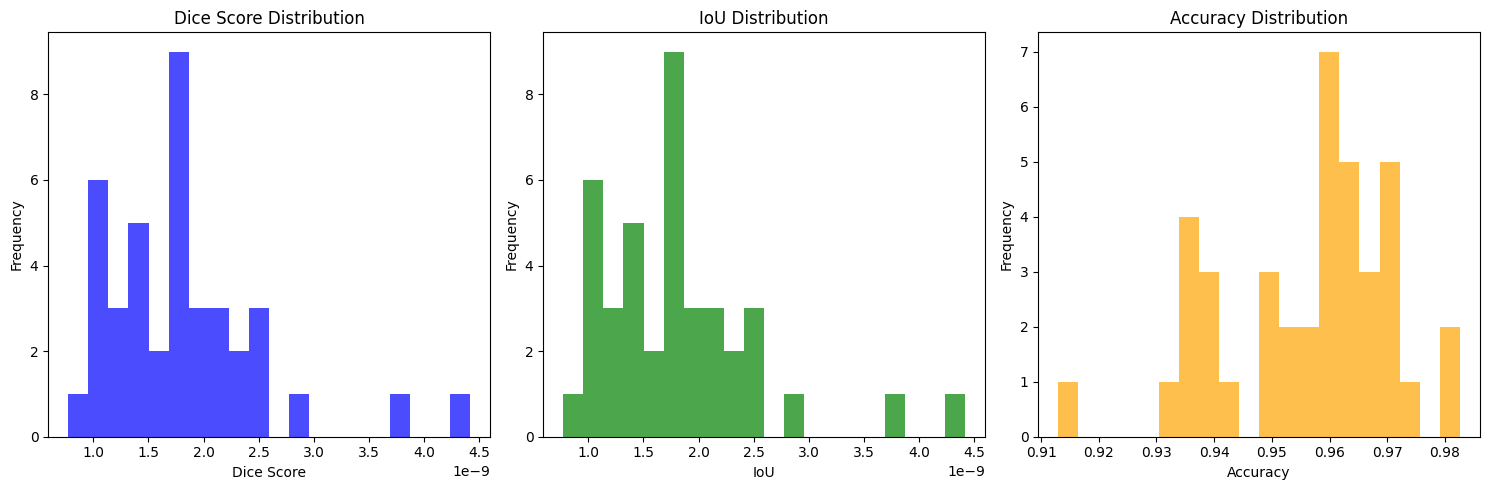

In [21]:
import matplotlib.pyplot as plt

# Plot metrics
plt.figure(figsize=(15, 5))

# Dice Score
plt.subplot(1, 3, 1)
plt.hist(dice_scores, bins=20, color='blue', alpha=0.7)
plt.title('Dice Score Distribution')
plt.xlabel('Dice Score')
plt.ylabel('Frequency')

# IoU
plt.subplot(1, 3, 2)
plt.hist(iou_scores, bins=20, color='green', alpha=0.7)
plt.title('IoU Distribution')
plt.xlabel('IoU')
plt.ylabel('Frequency')

# Accuracy
plt.subplot(1, 3, 3)
plt.hist(accuracy_scores, bins=20, color='orange', alpha=0.7)
plt.title('Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


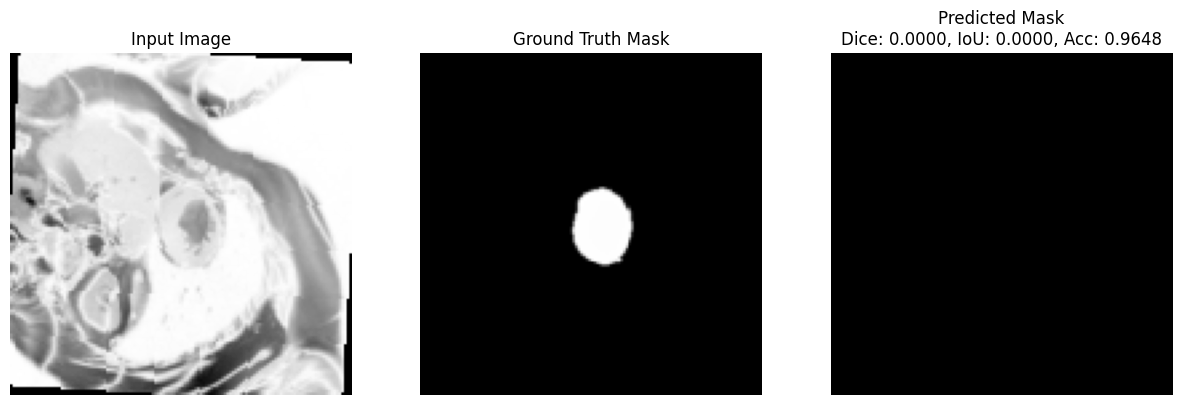

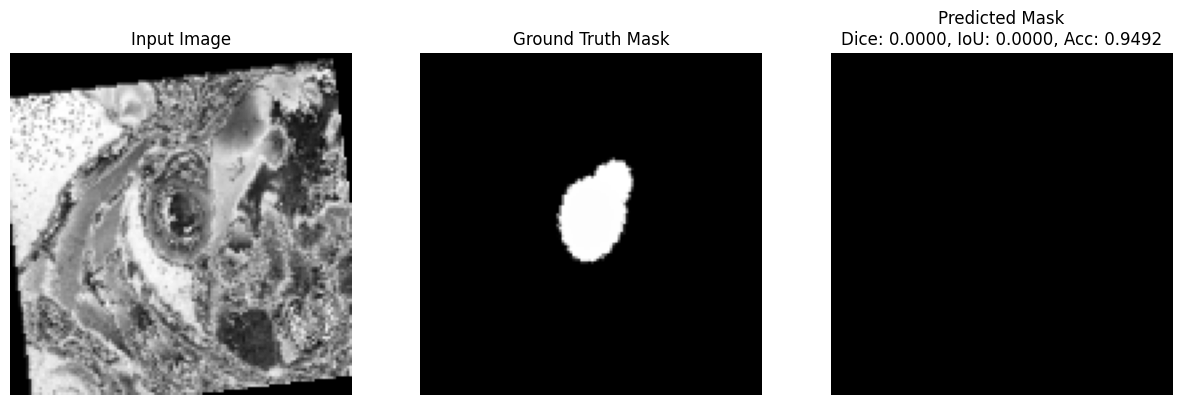

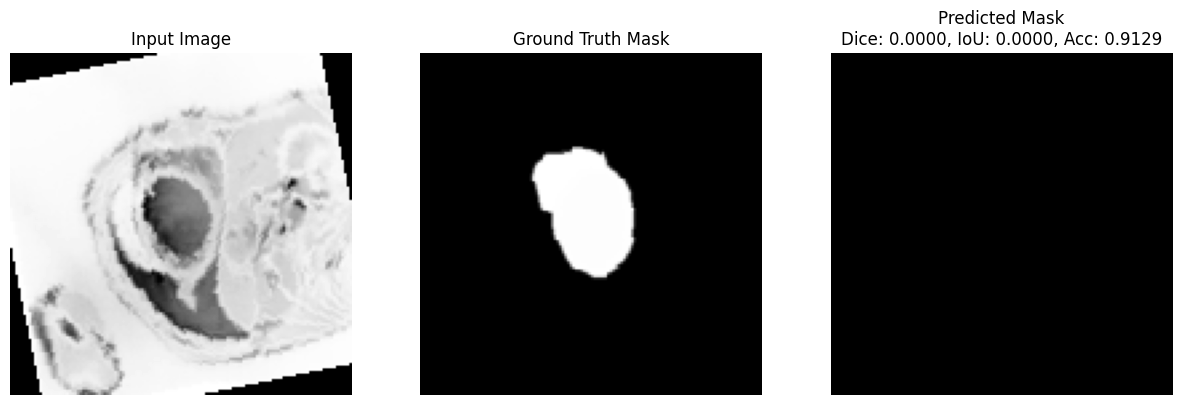

In [22]:
def visualize_metrics(model, loader, num_samples=3):
    model.eval()
    count = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:])
            preds = (outputs > 0.5).float()

            for i in range(images.shape[0]):
                if count >= num_samples:
                    return
                pred_np = preds[i, 0].cpu().numpy()
                mask_np = masks[i, 0].cpu().numpy()

                dice = dice_coefficient(pred_np, mask_np)
                iou_val = iou(pred_np, mask_np)
                acc = accuracy(pred_np, mask_np)

                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(images[i, 0].cpu(), cmap="gray")
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(mask_np, cmap="gray")
                plt.title("Ground Truth Mask")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_np, cmap="gray")
                plt.title(f"Predicted Mask\nDice: {dice:.4f}, IoU: {iou_val:.4f}, Acc: {acc:.4f}")
                plt.axis("off")

                plt.show()
                count += 1

# Visualize metrics with predictions
visualize_metrics(model, val_loader)
